# Intermediate - Statistical Tests & Regression

Intermediate Section Activities (Statistical Testing / Regression):
- Statistical libraries
    * Scipy, statsmodels
- Stats simulations
    * Use sims to determine desired sample size for some power of test
    * Alternatively evaluate power based on given sample size
- Create user defined functions
    * Write function for simulation
- Statistical Tests
    * Test for statistically significant difference in 1 gene between two cancer types
        * Do this for a specific gene identified as important for treatment
    * ANOVA on one gene versus all other cancer types
- Regression using library for 2 cancer types for specific gene(s)
    * Linear / Logistic regression


# Overview

This is the intermediate level notebook for the Data Science (DS) and Machine Learning (ML) FredHutch.io tutorial, where we will work through beginning to end on different aspects and techniques in DS for Research and Analysis.

In this notebook we will work through the process of data analysis for the [gene expression cancer RNA-Seq Data Set](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). **We will be using some findings from the Beginner Tutorial Notebook.**

This is the intermediate notebook and we will  focusing specifically on statistical testing and regression models in **python**. We will keep working with *python libraries* introduced in the Beginner Tutorial and introduce some new libraries with special purposes in statistics.
> **Libraries Used in This Tutorial**
* Data Manipulation and Processing
     - [pandas]( https://pandas.pydata.org/)
     - [numpy]( https://numpy.org/)
* Data Visualization
	- [Matplotlib](https://matplotlib.org/)
    - [Seaborn](https://seaborn.pydata.org/)
    - [Altair](https://altair-viz.github.io/)
* Statistics
    - [Scipy](https://www.scipy.org/)
    - [Statsmodels](https://www.statsmodels.org/stable/index.html)

## Questions

In this Notebook, we are focused on figuring out the statistically significant differences in genes between cancer groups. We are also concerned with determining statistical power our experiment given the genes data inspired by the PANCAN dataset.

# Table of Contents

[1. Statistical Background](#1.-Statistical-Background)

* [1.1 Power Calculations](#1.1-Power-Calculations)


[2. Setup](#1.-Setup)

* [1.1 Importing Libraries](#1.1-Importing-Libraries)


## 1. Statistical Background

### 1.1 Statistical Power and Sample Size Calculations

In designing our experiments, one of the most important aspects is the choice of a proper sample size, too small we wont yield useful information, too large we then waste time and resources.

To find an answer to our main questions in this notebook, and any research in general, we must decide which particular alternative *Hypothesis*, or *$H_{1}$*, are important to be able to detect with high ***power***.

In statistics, we refer to the **power** of an experiment as the control over the *type II* error rate:

> **Power = *P* (Reject *$H_{0}$* given that the alternative *$H_{1}$* holds)**  
Also written as  
**Power = 1 - *P* (Type II error) = 1 - $\beta$**

Power calculations are an important aspect of experimental design, as it might tell us if the results of our study are statistically significant or even if results from previous studies are incorrect.  

We can perform the calculations in a variety of ways:
* formulas
* simulations
* on-line calculators, *like this [one]( https://www.stat.ubc.ca/~rollin/stats/ssize/n2.html)*
* commercial software

In this notebook we’ll work with both simulations and formulas. These formulas are based on familiar assumptions such as:
- independence  
- normality of errors  
- constant variance 

so are often thought of as an initial rough calculation of power.

The formulas we will be using are then derived from the general formula for the Z test statistic
> $$
Z=\frac{\overline X - \mu_{0}}{\frac{\sigma}{\sqrt[]{n}}} \\	
$$
$\overline X$ - sample mean  
$\mu_0$ - population mean (Null Hypothesis)  
$\sigma$ - standard deviation  
$n$ - sample size  


We algebraically manipulate the formula and allow for $Z$ to be dependent on the desired significance level $\alpha$ for the quantile values in the Normal Distribution, $N(0,1)$. The power of the test for a mean is _increased_ by:

1. Increasing the difference between the means under the
null and alternative hypotheses ($\mu_1 - \mu_0$).
2. Increasing the significance level ($\alpha$).
3. Decreasing the standard deviation ($\sigma$).
4. Increasing the sample size ($n$).

#### 1.1.1 One-Sample Population Calculations

> $$
\hbox{Power} = P\left( N(0,1) <
	-Z_{1 - \alpha / 2} + \frac{ |\mu_1 - \mu_0|}{ \sigma / \sqrt n } \right) = 	\Phi(-Z_{1 - \alpha / 2} + \frac{ |\mu_1 - \mu_0|}{ \sigma / \sqrt n } ),
$$
where $\Phi$ is the cdf of the N(0,1) distribution.

The sample size that is required in order to have power equal to $1-\beta$:
> $$
	n = \frac{ \sigma^2 (Z_{1 - \beta} + Z_{1 - \alpha / 2})^2}{ (\mu_0 - \mu_1)^2 }.
$$

#### 1.1.2 Comparing Two Samples Calculations

When looking at comparing 2 samples, we consider the test of $H_0:\mu_A=\mu_B$ versus
$H_0:\mu_A\neq\mu_B$, where $\mu_A$ and $\mu_B$ are
means of two populations. Assuming a known population
variance $\sigma^2$ and sample sizes $n$ per group,
test statistic is 
> $$
Z=\frac{|\bar X_A - \bar X_B|}{\sqrt{\sigma_A^2/n_A+\sigma_B^2/n_B} },
$$

As a result, our power and sample size formulas become
> $$
\hbox{Power} = \Phi ( -Z_{1 - \alpha / 2} + \frac{|\Delta|}{ \sqrt{\sigma_A^2/n_A+\sigma_B^2/n_B}} ),
$$  
$$
n = \frac{ (\sigma_A^2+\sigma_B^2) (Z_{1 - \beta} + Z_{1 - \alpha/2})^2}{ \Delta^2 }.
$$

Where $|\Delta|=|\mu_A - \mu_B|$.

## 2. Setup

We will be moving from the PANCAN dataset to the genes data (datasets available [here](https://www.dropbox.com/sh/jke9h4km90ner9l/AAD1UyucvlXIFbKTjl-D15U6a?dl=0)) from the same five cancer types (BRCA, KIRC, COAD, LUAD, PRAD) from the TCGA projects available from the [National Cancer Institute's Genomic Data Commons](https://gdc.cancer.gov/). 

The we will be using the genes and metadata datasets for our statistical experiments since the metadata provides some interesting subgroups for the cancers which we can create test for. We will also use some genomic data background information from cancer from COSMIC: [Catalog Of Somatic Mutations In Cancer](https://cancer.sanger.ac.uk/). A caveat about this genes dataset, while inspired by the PANCAN dataset, it is almost double the size of the PANCAN and we will likely have to deal with this memory usage. 


### Questions about Experimental Design
Within our experimental purposes, we are interested in designing an experiment to figure out the possible effectiveness of the new drug *Pilaralisib* on Lung cancer. We know from research found in the COSMIC website that
> *Mutations in BRCA1 (gene ***ENSG00000134982***) are associated with altered sensitivity to Pilaralisib*
- https://cancer.sanger.ac.uk/cosmic/gene/analysis?ln=APC

In order to do this, we will use the fact that *Pilaralisib* is used to inhibit activity from Breast Cancer and has been shown to be responsive to gene **ENSG00000134982**. We will compare the mean response for the gene **ENSG00000134982** for both Breast Cancer samples and Lung Cancer samples(*Mirin* gene **ENSG00000012048**).

We would like to know how much power there will be to detect the alternative hypothesis of interest, which is that there is a difference in the mean response for the RNA-Seq, for sample sizes of 150 for each Cancer Type group. If the power is lower than 80%, what sample size will be required to reach 80%, 85%, and 90%. 



### 2.1 Importing Libraries

We will be using all the libraries from the previous tutorial notebook, but we will also introduce three libraries for statistics and data purposes:
> scipy  
statsmodels  
sklearn


In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Statistics
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# visualization
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

# setting up the plot style
plt.style.use('ggplot')
%matplotlib inline

Ok so as we know from the Novice Tutorial, we have a very large dataset and could possibly lead to large memory usage. We will use our *metadata.csv* file to create a smaller subset that we hope will contain a representation of the larger dataset. We could go ahead and subset the genes dataset the same way we did in the Novice Notebook, however we have the possibility of not obtaining an sample representative of the dataset. The great thing about our large dataset, this gives us a pseudo way of replicating how we might go about performing a real statistical experiment.

We will follow the same process as we did in the Novice Notebook so we will just put it into a python function so we can reuse it later if needed it.


In [8]:
def create_genes_subset(split_size=.1):
    """
        Creates a smaller dataframe from the large 'genes.csv' file based on a split from the metadata file.
        Returns a dataframe that has been transformed by log2 and the index needed for the remaining samples
        from the genes.csv file to remain independent.
    
    """
    
    metadata = pd.read_csv('../metadata.csv')
    
    big_split, small_split = train_test_split(metadata, test_size=split_size, random_state=4)
    
    skiplines_small = np.sort(big_split.index) + 1 
    skiplines_big = np.sort(small_split.index) + 1
    
    genes_small = pd.read_csv('../genes.csv', skiprows=skiplines_small)
    
    genes_nonAllZero = genes_small.loc[:,~genes_small.isin([0]).all(axis=0)]
    
    genes_log2_trans = np.log2(genes_nonAllZero.iloc[:,1:] + 1)
    genes_log2_trans['barcode'] = genes_small['barcode']
    
    genes_merged = pd.merge(left=small_split, right=genes_log2_trans, how='left', left_on='barcode', right_on='barcode')
    
    return genes_merged, big_split, small_split

We have the function to return the smaller subset from the larger *genes.csv*. This is very useful as we can create a pseudo version of what it would be to have design an experiment. Given we are trying to figure out sample size and power, often use a value for the standard deviation from a previous study or a study done in a different, but comparable, population. This way we can approximate this type of scenario.

In [9]:
# load the data from function, we need to set up the correct variable names since 2 things are returned
genes_small_log2, big_meta, small_meta = create_genes_subset()

In [10]:
genes_small_log2.head(3)

,barcode,shortLetterCode,tumor_stage,age_at_diagnosis,year_of_diagnosis,alcohol_history,race,ethnicity,gender,vital_status,...,ENSG00000281880,ENSG00000281883,ENSG00000281887,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281910,ENSG00000281912,ENSG00000281920
0,TCGA-YL-A8HJ-01A-11R-A36G-07,TP,not reported,21416.0,2009.0,Not Reported,white,not hispanic or latino,male,Alive,...,0.0,9.514700,0.000000,16.623075,11.229908,0.000000,0.000000,11.648106,14.595309,10.197190
1,TCGA-OL-A66K-01A-11R-A29R-07,TP,stage iia,26299.0,2010.0,Not Reported,white,not hispanic or latino,female,Dead,...,0.0,0.000000,7.541357,15.186443,10.850017,7.744871,10.110324,0.000000,14.185199,11.460256
2,TCGA-D8-A1X7-01A-11R-A14M-07,TP,stage iia,14858.0,2010.0,Not Reported,white,not hispanic or latino,female,Alive,...,0.0,7.371455,0.000000,16.080059,11.664703,0.000000,0.000000,11.083273,12.384756,10.953567


Great!!! Now we have both our gene expression data but also some demographics attached to them.

We now need to get the data for the Breast and Lung cancer for the **ENSG00000134982** gene to figure out if we have enough power with our current sample size and if not, what size is needed.



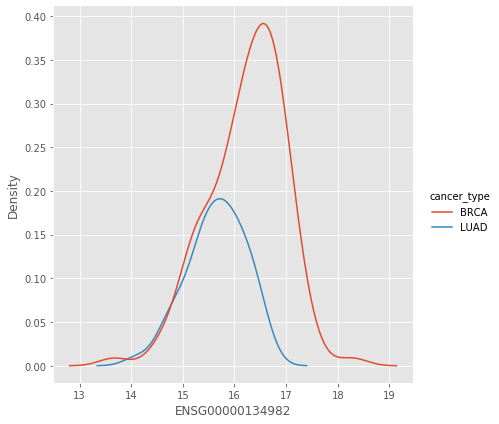

In [29]:
sns.displot(data=genes_small_log2.loc[genes_small_log2.cancer_type.str.contains('|'.join(['BRCA','LUAD']))], x="ENSG00000134982", 
            hue="cancer_type", kind="kde", height=6)

plt.show()

Ok we have a normal distribution for each of the cancer types in our data subset. 

Let's now create functions for the power and sample size calculations. For now we will make sure to run our simulations at an $\alpha = 0.5$.

In [34]:
np.random.seed(8911) # We set a seed for our random number generator for repudicibility

breast_cancer_ssample = genes_small_log2.loc[genes_small_log2.cancer_type == 'BRCA', ['ENSG00000134982']]
lung_cancer_ssample = genes_small_log2.loc[genes_small_log2.cancer_type == 'LUAD', ['ENSG00000134982']]

mu_0 = np.mean(breast_cancer_ssample.values) # mean of the first group
mu_1 = np.mean(lung_cancer_ssample.values) # mean of second group
sd_0 = np.std(breast_cancer_ssample.values) # first Population SD
sd_1 = np.std(lung_cancer_ssample.values) # second Population SD

# the parameters for our samples and number of simulations
n = 150 # Number of samples
N = 10000 # Number of simulations

def simulation_values(N,n,mu_0,mu_1,sd_0,sd_1, unequal_var=False):
    """
        Runs Monte-Carlo simulations for a Normal Distributions of the described means and standard dev. 
    
    """
    sims = []
    for i in range(N):
        
        # we can use either numpy or scipy.stats to create a sample of size n from a distribution
        # stats.norm.rvs(loc=mu, scale=sd, size=n), the scipy.stats version
        samples_0 = np.random.normal(loc=mu_0, scale=sd_0, size=n)
        samples_1 = np.random.normal(loc=mu_1, scale=sd_1, size=n)
        
        if unequal_var == True:
            critical_value, sds = unequal_variances(samples_0, samples_1, n)
        
        else:
            critical_value = sp.stats.t.ppf(0.025, 2*n-2)
            sds = sd_0**2/n + sd_1**2/n
        
        t = (np.mean(samples_0) - np.mean(samples_1))/np.sqrt(sds)
        sims.append(np.abs(t) > np.abs(critical_value))
    
    return np.array(sims)



def unequal_variances(sample1, sample2, n):
    """
        Formula for calculating the degrees of freedom and standard dev for samples of unequal variances
    
    """
    sd1 = np.std(sample1)**2
    sd2 = np.std(sample2)**2
    sds = sd1/n + sd2/n
    degf = ((sds)**2) / ((sd1/n)**2/(n-1) + (sd2/n)**2/(n-1))
    critical_value = stats.t.ppf(0.025, degf)
    
    return critical_value, sds

    
def sample_size_required(power,N,n,mu_0,mu_1,sd_0,sd_1, unequal_var=False):
    """
        Calculates the minimum sample size needed to achive desired power
    
    """
    sim_power = 0
    power_values = list()
    while(sim_power <= power):
    
        simulation_value = [np.mean(simulation_values(N,n,mu_0,mu_1,sd_0,sd_1, unequal_var))]
        sim_power = np.mean(simulation_value)
        power_values.append([sim_power])
        
        n += 1
        
        print(n, sim_power)
    
    return n, np.array(power_values)
    
# print(sample_size_required(.90,N,n,mu_0,mu_1,sd_0,sd_1, unequal_var=True))
    
    

In [35]:
n, power_values = sample_size_required(.90,N,n,mu_0,mu_1,sd_0,sd_1, unequal_var=True)

151 1.0


In [36]:
sims = simulation_values(N,n,mu_0,mu_1,sd_0,sd_1, unequal_var=True)

In [39]:
mu_0, mu_1, sd_0, sd_1

(16.235745618518706,
 15.649090903071922,
 0.7306102623212777,
 0.5560191022003984)